In [188]:
from draw_random_maps import *
from load_state_data import *

In [189]:
def plot_redblue_notebook(df, dcol="G20PREDBID", rcol="G20PRERTRU", num_dists=14):
    '''
    Plot a map that color-codes each precinct by the partisan margin of the vote
    in the district it's part of, i.e. dark blue if it largely voted Democratic,
    dark red if it overwhelmingly voted Republican, and white if it was close to even.

    Inputs:
        -df (geopandas DataFrame): state data by precincts/VTDs, with polygons
        -dcol (str): Name of column that contains Democratic voteshare data
        (i.e. estimated number of votes cast for Joe Biden in the precinct in
        the November 2020 presidential election)
        -rcol (str): Name of the column that contains Republican voteshare data
        (i.e. estimated number of votes cast for Donald Trump in the precinct
        in the November 2020 presidnetial election)
        -num_dists (int):
        -export_to (str or None): TODO: location to export the map to

    Returns: None, displays plot on screen and/or saves image to file
    '''
    
    #TODO: Move this to df setup, and have it be by precinct, with dissolve aggfunc-ing it 
    df['raw_margin'] = None
    for i in range(1, num_dists+1): #this should be doable on one line vectorized
        df.loc[df.dist_id == i, 'raw_margin'] = blue_red_margin(df, dcol, rcol, i)

    #TODO: figure out how to push legend off map, or maybe turn it into categorical color bar
    df.plot(column='raw_margin', cmap='seismic_r')
    #fig, ax = plt.subplots(1)
    #sm = plt.cm.ScalarMappable(cmap='seismic_r')
    #cbar = fig.colorbar(sm) #all of these extremely basic things from many matplotlib StackOverflow answers fail

    plt.pyplot.show()

In [229]:
def load_state(state_input, init_neighbors=False, affix_neighbors=True):
    '''
    Helper function that actually imports the state after selecting it.

    Inputs:
        -state_input (str): 2-letter state postal code abbreviation
    Returns (geopandas GeoDataFrame)
    '''
    state_fullname = [k for k, v in SUPPORTED_STATES.items() if v == state_input][0] #DRY

    print(f"Importing {state_fullname} 2020 Redistricting Data Hub data...")
    fp = f"merged_shps/{state_input}_VTD_merged.shp"
    state_data = gpd.read_file(fp)
    if "Tot_2020_t" in state_data.columns:
        state_data.rename(columns={"Tot_2020_t","POP100"})
        print("Renamed population column to POP100")
    print(f"{state_input} 2020 Redistricting Data Hub shapefile data imported")
    if init_neighbors:
        set_precinct_neighbors(state_data, state_input)
        print("Precinct neighbors calculated")
    if affix_neighbors: #maybe figure out how to do these as command line flags
        neighbor_fp = f'merged_shps/{state_input}_2020_neighbors.csv'
        affix_neighbors_list(state_data, neighbor_fp)
        print("Neighbors list affixed from file")
    state_data['dist_id'] = None

    return state_data   


In [230]:
df = load_state('GA')

Importing Georgia 2020 Redistricting Data Hub data...
GA 2020 Redistricting Data Hub shapefile data imported
Neighbors list affixed from file


In [231]:
draw_dart_throw_map(df, num_districts = 14)

Clearing off previous district drawings, if any...
Throwing dart for district 1 at precinct 13123000008...
Throwing dart for district 2 at precinct 1314100004A...
Throwing dart for district 3 at precinct 13127005913...
Throwing dart for district 4 at precinct 131210005A2...
Throwing dart for district 5 at precinct 13285000003...
Throwing dart for district 6 at precinct 13245000707...
Throwing dart for district 7 at precinct 1312100SS01...
Throwing dart for district 8 at precinct 1329900200B...
Throwing dart for district 9 at precinct 1305900006D...
Throwing dart for district 10 at precinct 1306700DC01...
Throwing dart for district 11 at precinct 1331500005A...
Throwing dart for district 12 at precinct 1312100007H...
Throwing dart for district 13 at precinct 13217000004...
Throwing dart for district 14 at precinct 13215000118...
2684 unfilled precincts remain
2609 unfilled precincts remain
2468 unfilled precincts remain
2243 unfilled precincts remain
1953 unfilled precincts remain
1614 

c:\Users\Ethan\30122-project-redistricting-redux\.venv\lib\site-packages\geopandas\plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)


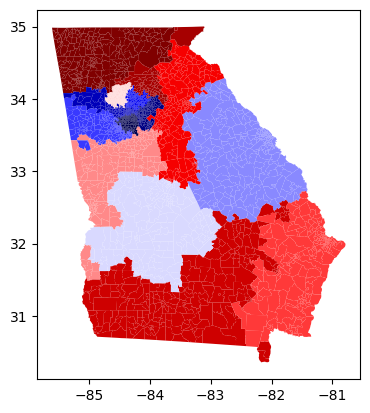

In [228]:
plot_redblue_notebook(df, dcol="G20PREDBID", rcol="G20PRERTRU", num_dists=14)

In [223]:
neighbor_dict = {
    id: n for (id, n) in zip(df.GEOID20, df.neighbors)
}

In [224]:
df_trade = pd.DataFrame(df)
df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\2018466249.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


In [232]:
run = 0
run_dict = {}

In [233]:
def batch_balance_transfer(df, run=run, run_dict=run_dict, allowed_deviation=70000):
    '''
    Identifies the border between the smallest population and its largest
    neighbor and trade all precincts on that border from the larger district
    to the smaller district. This is a heavy-handed approach, but
    it does a lot of balancing before a slower, more careful approach is needed.

    Inputs:
        -df (geopandas GeoDataFrame): state data by precinct/VTD. Every precinct 
        should have a dist_id assigned before calling this function.
        -allowed_deviation (int): Largest allowable difference between the 
        population of the most populous district and the population of the 
        least populous district.
    
    Returns: none, modifies df in-place.
    '''
    df_trade = pd.DataFrame(df)
    df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()
    recent_transfer = []
    while (df_trade_pop.POP100.max() - df_trade_pop.POP100.min()) > allowed_deviation:
    #small districts take
        df_trade = pd.DataFrame(df)
        df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()

        smallest = df_trade_pop[df_trade_pop.POP100 == min(df_trade_pop.POP100)]

        df_rec = df[df.dist_id == smallest.dist_id.item()]

        dist_nabes = []
        nabe_other_dist = []
        for prec in df_rec['GEOID20']:
            nabes = neighbor_dict[prec]
            for n in nabes:
                if len(n) != 22:
                    dist = df[df.GEOID20 == n].dist_id.item()
                    if dist != smallest.dist_id.item():
                        dist_nabes.append(dist)
                    
                    nabe_other_dist.append(n)


        dist_set = set(dist_nabes)

        neighbor_pop_dict = {}
        for i in dist_set:
            pop = df_district_pop[df_district_pop.dist_id == i]["POP100"].item()
            neighbor_pop_dict[i] = pop

        max = 0
        comp_district = None

        for k,v in neighbor_pop_dict.items():
            diff = abs(smallest.POP100.item() - v)
            if diff > max:
                comp_district = k
                max = diff


        eligible = [
            nabe for nabe in nabe_other_dist if df[
                df.GEOID20 == nabe
            ].dist_id.item() == comp_district]

        recent_transfer.append(eligible)
        
        df.loc[df['GEOID20'].isin(eligible), 'dist_id'] = smallest.dist_id.item()
        print(df_trade_pop.POP100.max() - df_trade_pop.POP100.min())

        if len(recent_transfer) > 4:
            recent_transfer.pop(0)
            if (recent_transfer[0] == recent_transfer[2]) and recent_transfer[1] == recent_transfer[3]:
                break 
            
        idx = {name: i for i, name in enumerate(list(df), start=1)}
        recapture_orphan_precincts(df, idx)
        run+=1
        run_dict[run] = df_trade_pop.POP100.max() - df_trade_pop.POP100.min()


In [234]:
def single_balance_transfer(df, run=run, run_dict=run_dict, allowed_deviation=70000):
    '''
    Identifies the border between the smallest population and its largest
    neighbor and trade all precincts on that border from the larger district
    to the smaller district. This is a heavy-handed approach, but
    it does a lot of balancing before a slower, more careful approach is needed.

    Inputs:
        -df (geopandas GeoDataFrame): state data by precinct/VTD. Every precinct 
        should have a dist_id assigned before calling this function.
        -allowed_deviation (int): Largest allowable difference between the 
        population of the most populous district and the population of the 
        least populous district.
    
    Returns: none, modifies df in-place.
    '''
    df_trade = pd.DataFrame(df)
    df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()
    recent_transfer = []

    second_choice = False
    while (df_trade_pop.POP100.max() - df_trade_pop.POP100.min()) > allowed_deviation:
    #small districts take
        df_trade = pd.DataFrame(df)
        df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()

        smallest = df_trade_pop[df_trade_pop.POP100 == min(df_trade_pop.POP100)]

        df_rec = df[df.dist_id == smallest.dist_id.item()]

        dist_nabes = []
        nabe_other_dist = []
        for prec in df_rec['GEOID20']:
            nabes = neighbor_dict[prec]
            for n in nabes:
                if len(n) != 22:
                    dist = df[df.GEOID20 == n].dist_id.item()
                    if dist != smallest.dist_id.item():
                        dist_nabes.append(dist)
                    
                    nabe_other_dist.append(n)


        dist_set = set(dist_nabes)

        neighbor_pop_dict = {}
        for i in dist_set:
            pop = df_trade_pop[df_trade_pop.dist_id == i]["POP100"].item()
            neighbor_pop_dict[i] = pop

        df_neighbor_pop = pd.DataFrame.from_dict(
            neighbor_pop_dict, orient = 'index').sort_values(
                0, ascending=False).reset_index()
        
        if not second_choice:
            comp_district = df_neighbor_pop.loc[0, 'index']
        else:
            print(df_neighbor_pop)
            comp_district = df_neighbor_pop.loc[1, 'index']


        eligible = [
            nabe for nabe in nabe_other_dist if df[
                df.GEOID20 == nabe
            ].dist_id.item() == comp_district]

        max_pop = 0
        transfer = None
        for e in eligible:
            if df.loc[df.GEOID20 == e, 'POP100'].item() > max_pop:
                max_pop = df.loc[3, "POP100"].item()
                transfer = e

        recent_transfer.append(transfer)


        df.loc[df['GEOID20'] == transfer, 'dist_id'] = smallest.dist_id.item()
        print(df_trade_pop.POP100.max() - df_trade_pop.POP100.min())

        # second choice mode is a way to inject some noise to prevent
        # trading precincts back and forth indefinitely

        second_choice_count = 0
        if second_choice:
            second_choice_count += 1
        
        # after 10 times trading to the second-choice district,
        # hopefully we can trade with the largest possible district again
        if second_choice_count == 10:
            second_choice = False
        if len(recent_transfer) > 4:
            recent_transfer.pop(0)
            if (
                recent_transfer[0] == recent_transfer[2]
                ) and (
                    recent_transfer[1] == recent_transfer[3]
                    ):
                if second_choice == False:
                    second_choice = True
                else:
                    second_choice = False
    
    idx = {name: i for i, name in enumerate(list(df), start=1)}
    recapture_orphan_precincts(df, idx)
    
    run+=1
    run_dict[run] = df_trade_pop.POP100.max() - df_trade_pop.POP100.min()

In [235]:

batch_balance_transfer(df)
print("Switching to single-precinct approach.")
single_balance_transfer(df)


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()
C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


659781
Reclaiming orphan precinct 13255000021...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


626847
Reclaiming orphan precinct 13245000806...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


591718


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


560208


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


559027


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


552625
Reclaiming orphan precinct 13293000561...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


551958
Reclaiming orphan precinct 132210000CR...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


547174


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


529756


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


526016
Reclaiming orphan precinct 13171001711...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


516536
Reclaiming orphan precinct 13003000004...
Reclaiming orphan precinct 1300700000N...
Reclaiming orphan precinct 13095000026...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


510553
Reclaiming orphan precinct 13195000COL...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


494305


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


492903
Reclaiming orphan precinct 13199000011...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


489061


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


485688


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


482769
Reclaiming orphan precinct 1310300005A...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


499371
Reclaiming orphan precinct 13195000HAR...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


479036


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


470690


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


463614


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


487862
Reclaiming orphan precinct 13321000003...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


453068


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


446575
Reclaiming orphan precinct 13137000004...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


443984
Reclaiming orphan precinct 1305900005C...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


418176


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


411057
Reclaiming orphan precinct 13285000009...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


408743
Reclaiming orphan precinct 13209000002...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


444124
Reclaiming orphan precinct 13095000027...
Reclaiming orphan precinct 13207000003...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


447789


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


404799
Reclaiming orphan precinct 1310300004C...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


442986
Reclaiming orphan precinct 13161000402...
Reclaiming orphan precinct 13277000005...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


441950


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


433285


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


412503
Reclaiming orphan precinct 13037000005...
Reclaiming orphan precinct 13095000026...
Reclaiming orphan precinct 13243000954...
Reclaiming orphan precinct 1324300718B...
Reclaiming orphan precinct 13293000561...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


400909
Reclaiming orphan precinct 13219000005...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


395962
Reclaiming orphan precinct 13077000015...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


437400
Reclaiming orphan precinct 13151000042...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


393561
Reclaiming orphan precinct 13255000014...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


383092


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


368118


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


367902


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


366963
Reclaiming orphan precinct 13219000009...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


411391


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


298353


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


296601
Reclaiming orphan precinct 13137000005...
Reclaiming orphan precinct 13281000990...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


282689


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


279583
Reclaiming orphan precinct 132050000HF...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


279032
Reclaiming orphan precinct 13077000025...
Reclaiming orphan precinct 13255000014...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


415839


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


384333


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


367323


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


324465
Reclaiming orphan precinct 13217000006...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


274436
Reclaiming orphan precinct 13217000006...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


358413
Reclaiming orphan precinct 13135000151...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


349383


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


271830


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


269691


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


269140


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


266326


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


262676


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


300283


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


275745


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


334699


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


285410
Reclaiming orphan precinct 13123000013...
Reclaiming orphan precinct 13227000011...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


267740


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


285483


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


279101


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


272569
Reclaiming orphan precinct 13057000009...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


288741


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


259961
Reclaiming orphan precinct 13157003000...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


319389
Reclaiming orphan precinct 13139000026...


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


314593


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


288741


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


314593


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\3380260959.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


288741
Switching to single-precinct approach.


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()
C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


314593


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


307609


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


299567


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


294292


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


288339


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


279083


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


271446


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


268674


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


260070


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


257515


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


252931


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


252103


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


251515


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


250978


C:\Users\Ethan\AppData\Local\Temp\ipykernel_10760\633365314.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_trade_pop = df_trade.groupby('dist_id').sum()[['POP100']].reset_index()


249819


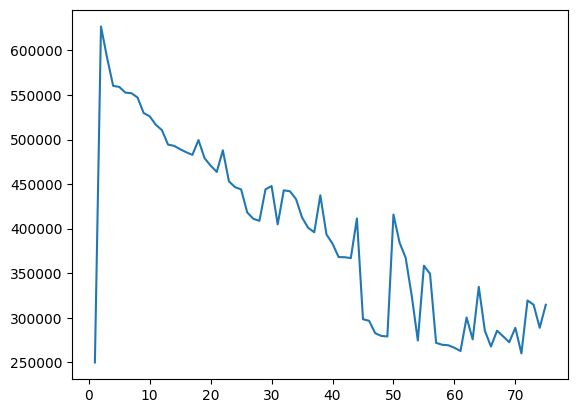

In [216]:
plt.pyplot.plot(run_dict.keys(), run_dict.values())